# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve

## LECTURA Y LIMPIEZA DEL DATASET

In [7]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)  #datos de entrenamiento (80% del dataset original)
df_orig.shape

(239, 13)

## Transformaciones necesarias al df

In [8]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)

#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [9]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]

In [10]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

(326, 6)

In [6]:
feat_train, feat_val, targ_train, targ_val = train_test_split(feat_train,targ_train,random_state=420,test_size=0.2)

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [11]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

# RED NEURONAL SIMPLE

In [12]:
keras.backend.clear_session()

In [13]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu",kernel_initializer='he_uniform')(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu",kernel_initializer='he_uniform')(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              metrics=["accuracy",tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_data=(feat_val,targ_val),
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

Epoch 1/2000
11/11 [==============================] - 1s 17ms/step - loss: 0.8309 - accuracy: 0.5031 - recall: 0.9816 - val_loss: 0.6529 - val_accuracy: 0.5909 - val_recall: 0.9744
Epoch 2/2000
11/11 [==============================] - 0s 2ms/step - loss: 0.7911 - accuracy: 0.5153 - recall: 0.9571 - val_loss: 0.6314 - val_accuracy: 0.6061 - val_recall: 0.9487
Epoch 3/2000
11/11 [==============================] - 0s 2ms/step - loss: 0.7544 - accuracy: 0.5215 - recall: 0.9325 - val_loss: 0.6159 - val_accuracy: 0.6515 - val_recall: 0.9487
Epoch 4/2000
11/11 [==============================] - 0s 2ms/step - loss: 0.7290 - accuracy: 0.5460 - recall: 0.9141 - val_loss: 0.6030 - val_accuracy: 0.6515 - val_recall: 0.9487
Epoch 5/2000
11/11 [==============================] - 0s 2ms/step - loss: 0.7030 - accuracy: 0.5644 - recall: 0.8957 - val_loss: 0.5950 - val_accuracy: 0.6667 - val_recall: 0.9231
Epoch 6/2000
11/11 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5859

In [25]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 500us/step - loss: 0.0703 - accuracy: 0.9877 - recall: 0.9939


[0.07025530934333801, 0.987730085849762, 0.9938650131225586]

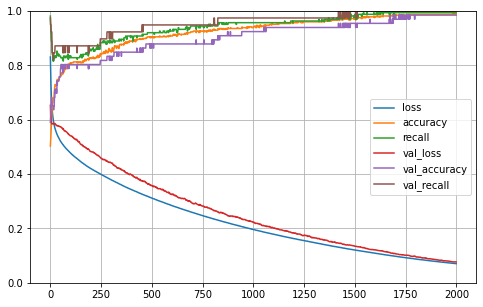

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
test_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_test.csv",index_col=0)
test_cleaned = test_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
feat_test, targ_test = test_cleaned.drop(["DEATH_EVENT"],axis=1),test_cleaned["DEATH_EVENT"]
feat_test = scaler.transform(feat_test)

In [23]:
from sklearn.metrics import confusion_matrix,recall_score

In [24]:
mask = model.predict(feat_test)>0.5
mask = 1*mask
recall_score(mask,targ_test)

0.7368421052631579

(array([135.,  18.,   5.,   3.,   0.,   2.,   5.,   4.,  16., 138.]),
 array([1.8865263e-07, 9.9999696e-02, 1.9999920e-01, 2.9999870e-01,
        3.9999822e-01, 4.9999771e-01, 5.9999722e-01, 6.9999671e-01,
        7.9999620e-01, 8.9999574e-01, 9.9999523e-01], dtype=float32),
 <BarContainer object of 10 artists>)

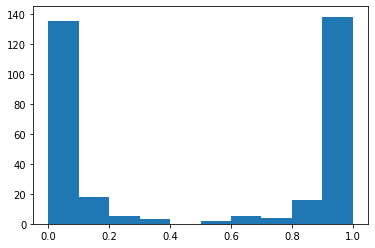

In [26]:
plt.hist(model.predict(feat_train))

(array([136.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 124.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

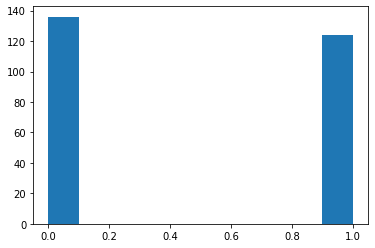

In [314]:
plt.hist(targ_train)

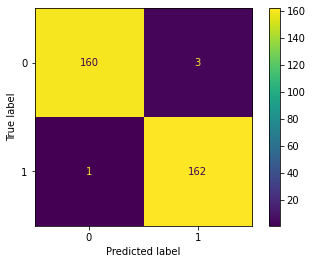

In [27]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()